In [ ]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 10
width = 10
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=100, width=100)

In [108]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

w = np.full(grid.shape + (2,), [0.0,0.0])

for j in range(3, 7):
    for i in range(3,8):
        # print(j,i)
        w[(j,i)] = [0.1, 0]

print(w)

cells = navier_stokes.cells(grid)
fluid_cells = [c for c in cells.flat if isinstance(c, navier_stokes.FluidCell)]
A = navier_stokes.projection_A(fluid_cells)
b = navier_stokes.projection_b(fluid_cells, w)

[[[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.1 0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0. ]


8
1.7639599868567264e-10


/Users/vladimirmakaric/anaconda3/envs/ai/lib/python3.11/site-packages/pyamg/classical/classical.py:97: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR',


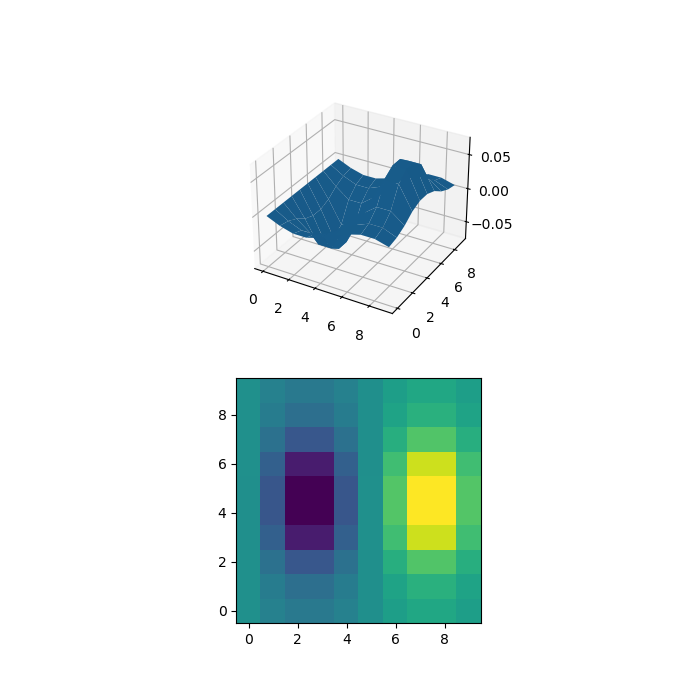

In [109]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=100, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)


mesh = np.zeros(shape=(height,width))

avg = np.average(x)
# print(avg)

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        mesh[cell.index] = avg
        continue
    if isinstance(cell, navier_stokes.FluidCell):
        mesh[cell.index] = x[cell.num]

for cell in cells.flat:
    if isinstance(cell, navier_stokes.BoundaryCell):
        w = np.array([1, 0])
        # g = (other_x*abs(nx) + other_y*abs(ny) + b)/(np.abs(nx + ny))
        an_x = np.abs(cell.normal[0])
        an_y = np.abs(cell.normal[1])
        mesh[cell.index] = np.dot(w, cell.normal)/(an_x + an_y)
        if cell.x_diff:
            mesh[cell.index] += mesh[cell.x_diff.fluid_cell.index]*an_x/(an_x + an_y)
        if cell.y_diff:
            mesh[cell.index] += mesh[cell.y_diff.fluid_cell.index]*an_y/(an_x + an_y)


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')
X, Y = np.meshgrid(np.arange(width), np.arange(height))
ax.plot_surface(X,Y,mesh) 
plt.show()

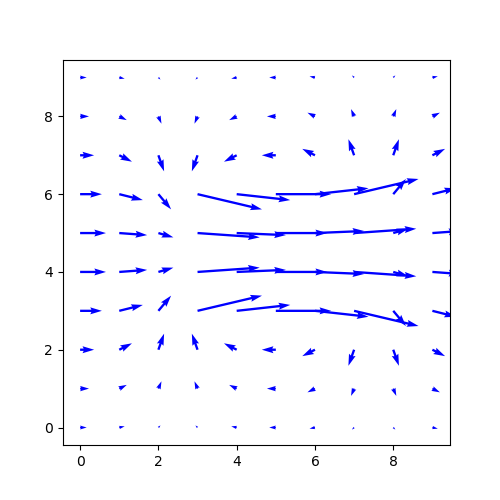

[0.08352273 0.01969697]
[0.06941288 0.00767045]
[ 7.17803030e-02 -4.88390686e-12]
[ 0.06941288 -0.00767045]
[ 0.08352273 -0.01969697]
new row
[0.08058712 0.00558712]
[0.06382576 0.00265152]
[6.64772727e-02 6.34448223e-13]
[ 0.06382576 -0.00265152]
[ 0.08058712 -0.00558712]
new row
[ 0.08058712 -0.00558712]
[ 0.06382576 -0.00265152]
[6.64772727e-02 6.06324702e-12]
[0.06382576 0.00265152]
[0.08058712 0.00558712]
new row
[ 0.08352273 -0.01969697]
[ 0.06941288 -0.00767045]
[7.1780303e-02 5.7693152e-12]
[0.06941288 0.00767045]
[0.08352273 0.01969697]
new row


In [112]:
gradP = np.zeros(shape=mesh.shape + (2,))

for cell in cells.flat:
    match cell:
        case navier_stokes.FluidCell(j=j, i=i):
            gradP[cell.index] = [
                (mesh[cell.right.index] - mesh[cell.left.index]) / 2,
                (mesh[cell.up.index] - mesh[cell.down.index]) / 2,
            ]
        case navier_stokes.BoundaryCell(j=j, i=i, x_diff=x_diff, y_diff=y_diff):
            if x_diff:
                gradP[cell.index][0] = (
                    mesh[x_diff.fluid_cell.index] - mesh[cell.index]
                ) * x_diff.dir
            if y_diff:
                gradP[cell.index][1] = (
                    mesh[y_diff.fluid_cell.index] - mesh[cell.index]
                ) * y_diff.dir

newW = w - gradP

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        newW[cell.index] = [0, 0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newW[:, :, 0], newW[:, :, 1], color="b")
# ax.quiver(X, Y, U,V, color="r")
plt.show()


for j in range(3, 7):
    for i in range(3,8):
        # print(j,i)
        print(newW[(j,i)])
    print('new row')

# print(newW)

In [52]:
a = np.array([
    [[1,2], [3,4]],
    [[5,6], [7,8]],
])
print(a[:,:,1])
# print(a[:][:][3])
# print(a)

[[2 4]
 [6 8]]
